In [189]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from datetime import timedelta

# Getting the data

We are using the python lybrary "yahoo_fin" to get the data from the yahoo api

In [52]:
df = get_data("^GSPC")
df.to_csv("df.csv")
df = df.drop('ticker', axis=1)
df.head()

open       high        low      close   adjclose    volume
1970-03-25   0.0  91.070000  88.110001  89.769997  89.769997  17500000
1970-03-26   0.0  90.650002  89.180000  89.919998  89.919998  11350000
1970-03-30   0.0  90.410004  88.910004  89.629997  89.629997   9600000
1970-03-31   0.0  90.169998  88.849998  89.629997  89.629997   8370000
1970-04-01   0.0  90.620003  89.300003  90.070000  90.070000   9810000

In [53]:
df.describe()


open          high           low         close      adjclose  \
count  13570.000000  13570.000000  13570.000000  13570.000000  13570.000000   
mean    1034.058651   1063.213975   1050.174998   1057.117464   1057.117464   
std     1132.856383   1118.809205   1106.121178   1112.863348   1112.863348   
min        0.000000     63.230000     60.959999     62.279999     62.279999   
25%      157.902496    158.535004    157.107506    157.982498    157.982498   
50%      754.784973    758.315002    747.650024    754.784973    754.784973   
75%     1396.865051   1404.312500   1386.480011   1397.537537   1397.537537   
max     4804.509766   4818.620117   4780.979980   4796.560059   4796.560059   

             volume  
count  1.357000e+04  
mean   1.578218e+09  
std    1.869560e+09  
min    6.650000e+06  
25%    8.100500e+07  
50%    4.716650e+08  
75%    3.277688e+09  
max    1.145623e+10

# Analyzing the time series
Now that we have the data we can start analyzing it
## Time series Plots

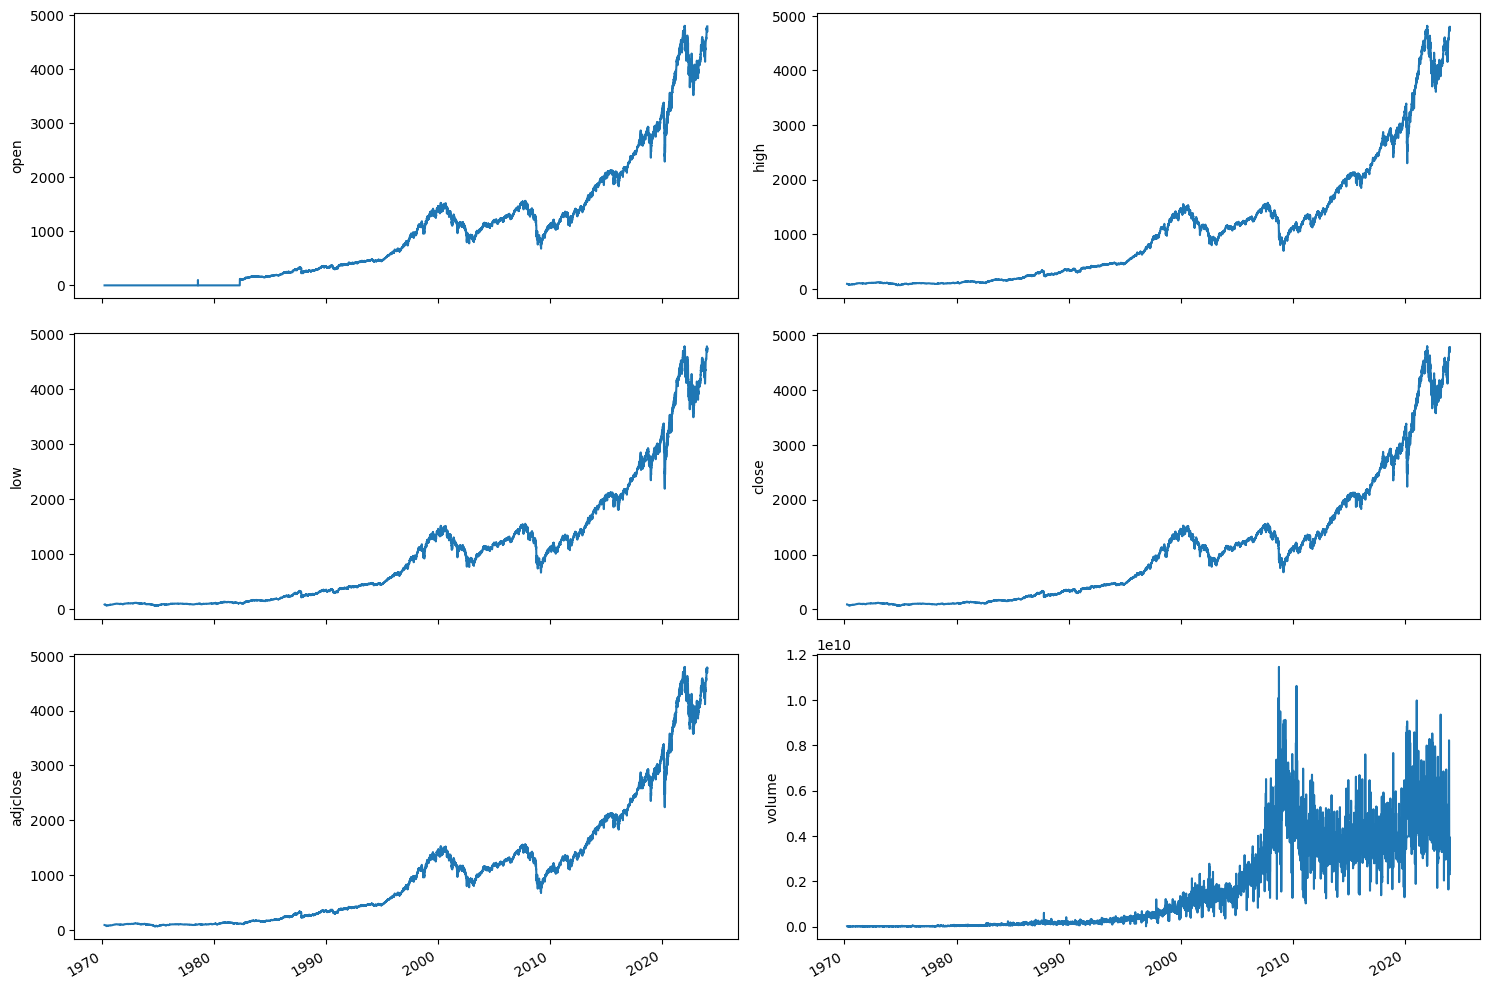

In [54]:
labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## Chossing variable to study

Because our data has multiple variables we need to decide on one to study we decided to use the variable "adjclose".

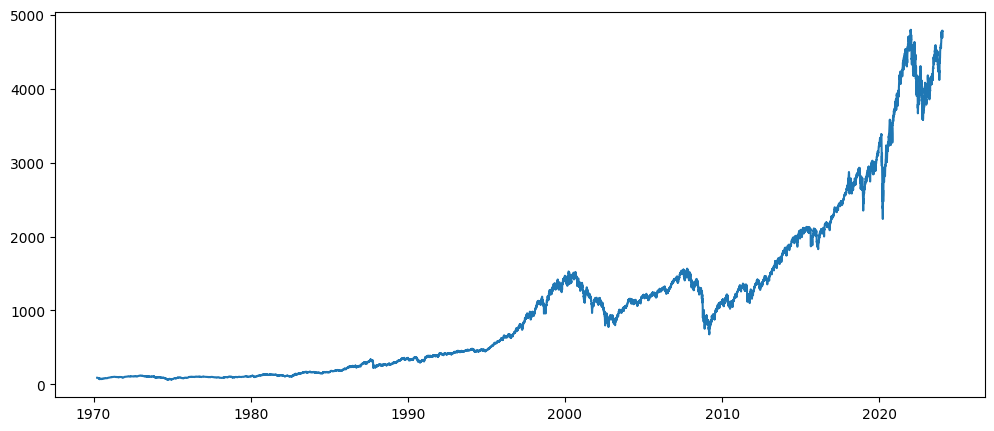

In [55]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

## Decomposing the time series

In [56]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=12, extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', period=12, extrapolate_trend='freq')
    
    return result_mul, result_add

def plot_decompostion(df, column_name, decomposition):
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df[column_name], label='Original TS')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.show()

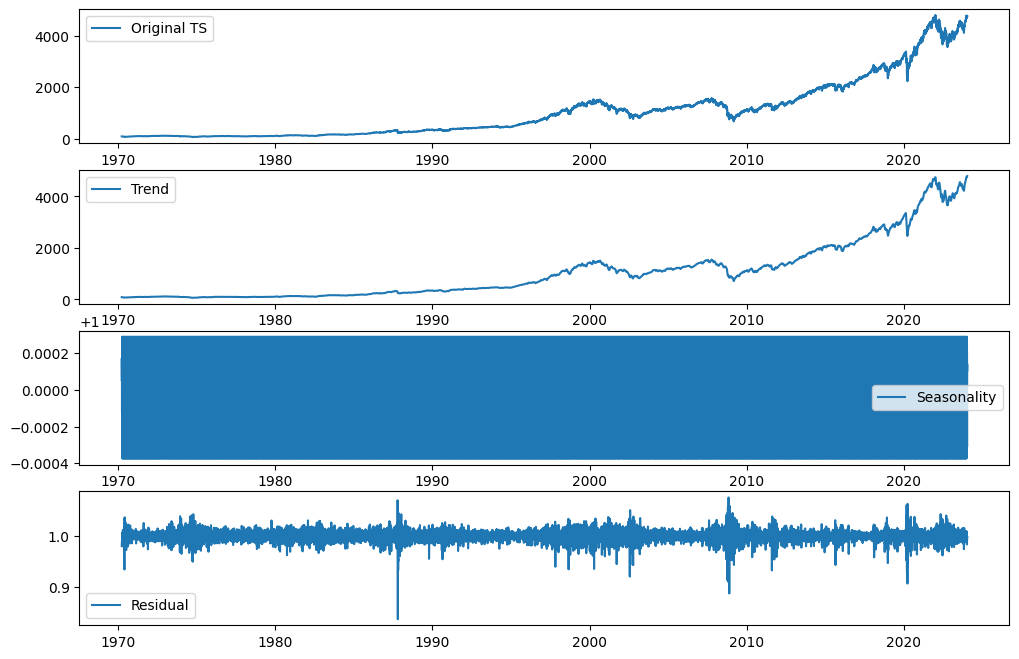

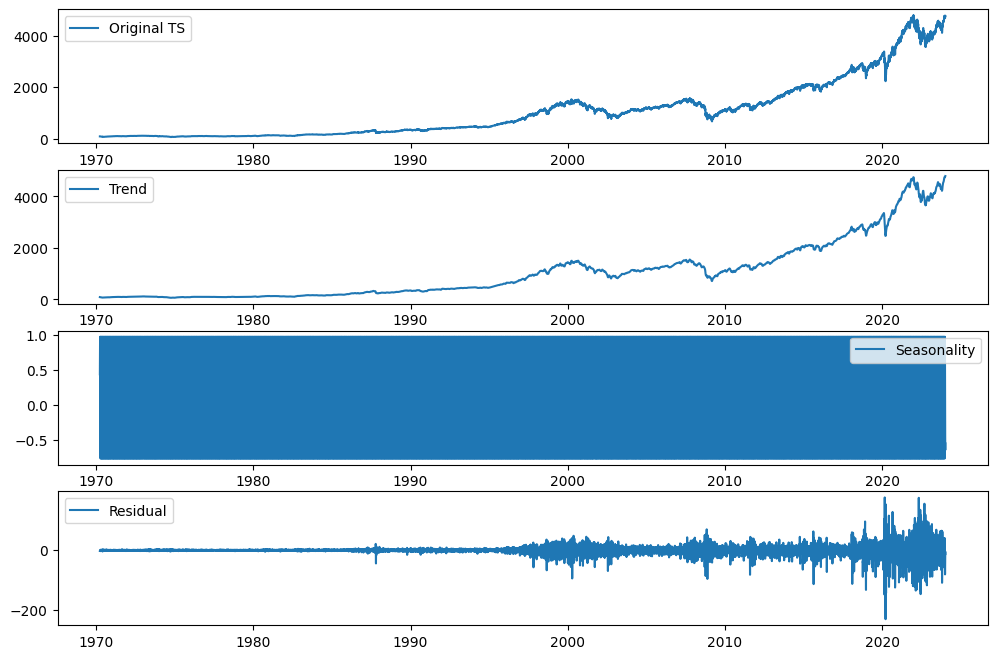

In [57]:
result_mult, result_add = seasonal_decomposition(df,var)

plot_decompostion(df,var,result_mult)
plot_decompostion(df,var,result_add)


### Auto-correlation function of the residuals of the decomposition

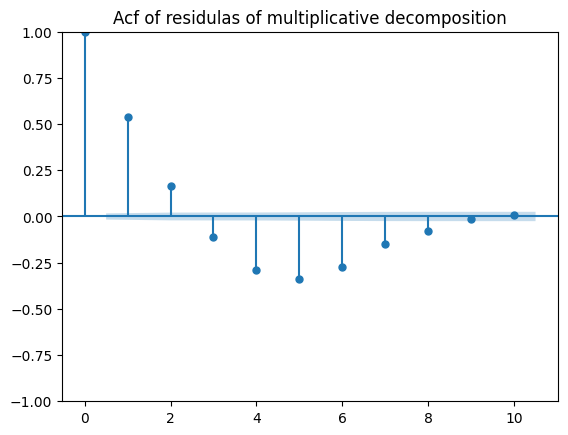

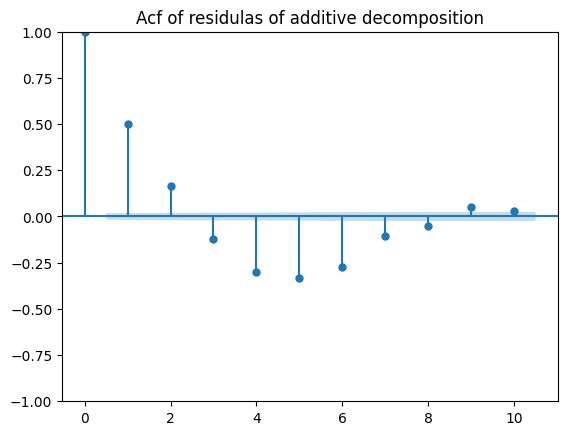

In [58]:
fig = tsaplots.plot_acf(result_mult.resid, lags=10)
plt.title('Acf of residulas of multiplicative decomposition')
plt.show()

fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.title('Acf of residulas of additive decomposition')
plt.show()

## Lag plots

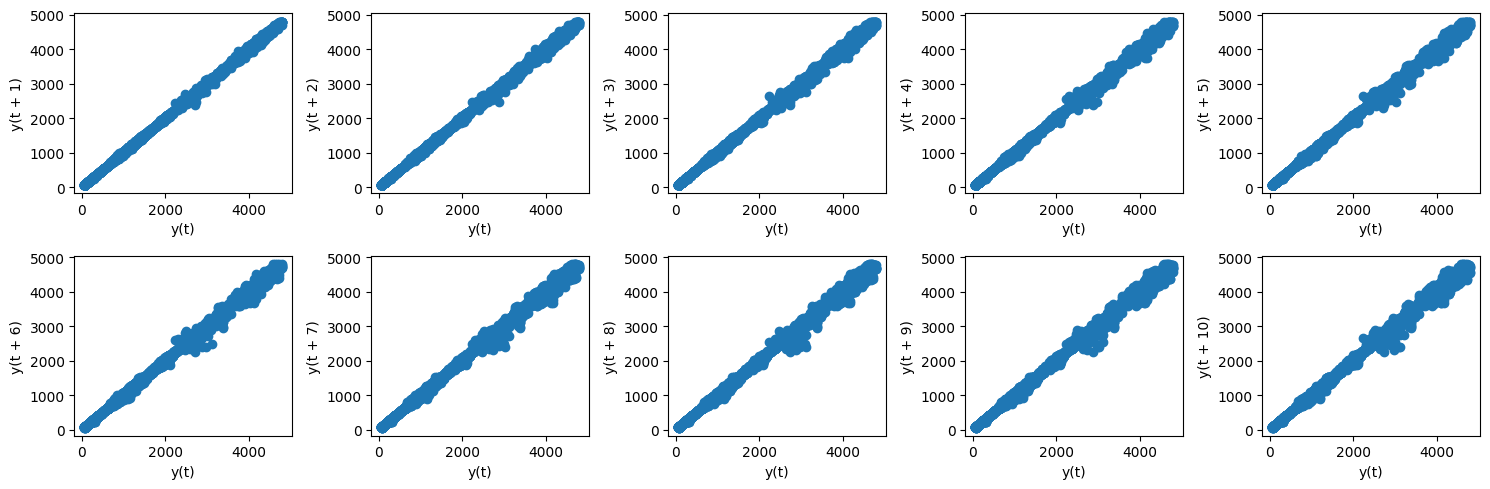

In [59]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


## ACF Plot

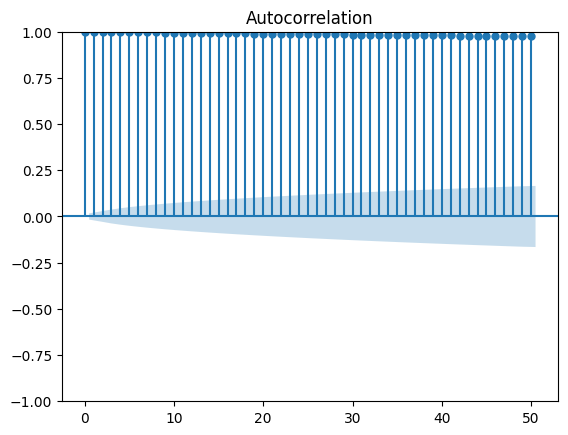

[1.         0.99943998 0.99889991 0.99835763 0.99781722 0.99729933
 0.99677937 0.99627181 0.99573645 0.99521325 0.99466396]


In [60]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=50)
plt.show()
print(acf)

# Analysing the daily difference

In [61]:
daily_diff = df.diff()
daily_diff = daily_diff.dropna()
daily_diff.describe()


open          high           low         close      adjclose  \
count  13569.000000  13569.000000  13569.000000  13569.000000  13569.000000   
mean       0.353168      0.346925      0.342801      0.345675      0.345675   
std       15.679994     13.587897     15.348954     17.219376     17.219376   
min     -194.739990   -164.650146   -228.359863   -324.890137   -324.890137   
25%       -1.699982     -1.539978     -1.680008     -1.869995     -1.869995   
50%        0.000000      0.110001      0.190002      0.139999      0.139999   
75%        2.970001      2.500000      2.869995      2.930054      2.930054   
max      170.039795    148.979980    172.180176    230.380127    230.380127   

             volume  
count  1.356900e+04  
mean   1.697575e+05  
std    4.460858e+08  
min   -5.044220e+09  
25%   -3.937000e+07  
50%    0.000000e+00  
75%    3.790000e+07  
max    4.637230e+09

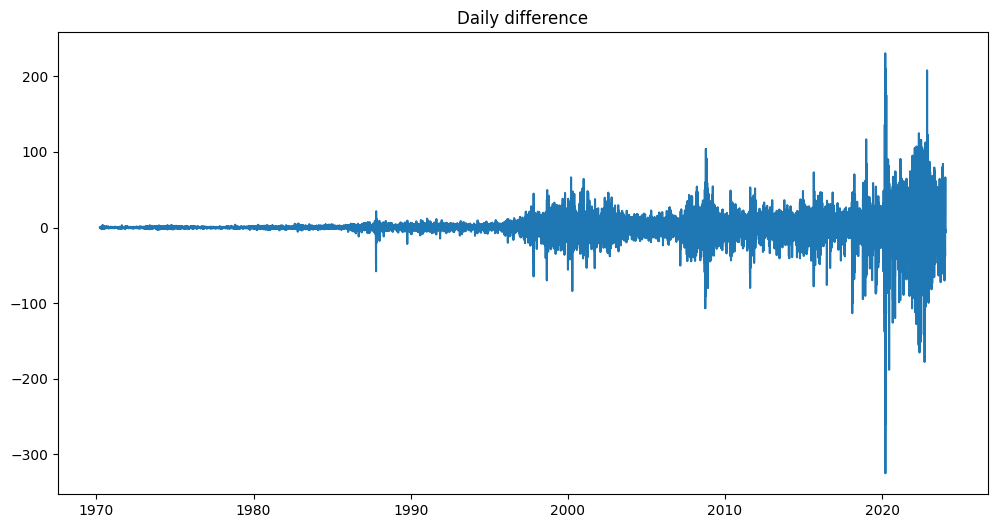

In [62]:
plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.title('Daily difference')
plt.show()

## Check for stationary

In [63]:
result = adfuller(daily_diff[var])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.\n\n")
else:
    print("The time series is non-stationary.\n\n")

result = kpss(daily_diff[var])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -20.009116166970482
p-value: 0.0
Critical Values: {'1%': -3.43083351751014, '5%': -2.8617536921137314, '10%': -2.5668837434507843}
The time series is stationary.


KPSS Statistic: 0.7640285011186798
p-value: 0.01
The time series is non-stationary.


C:\Users\GODA\AppData\Local\Temp\ipykernel_6360\3128835151.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(daily_diff[var])


## ACF of daily differences

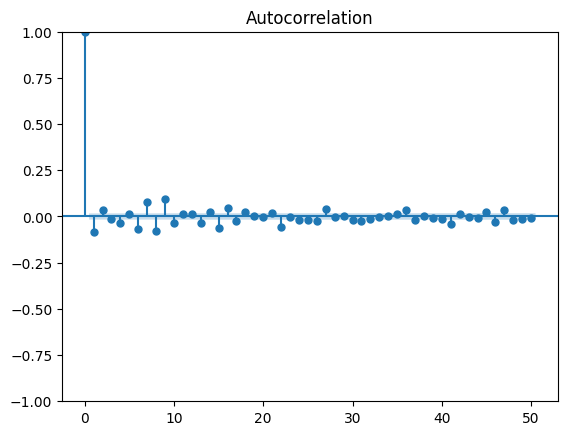

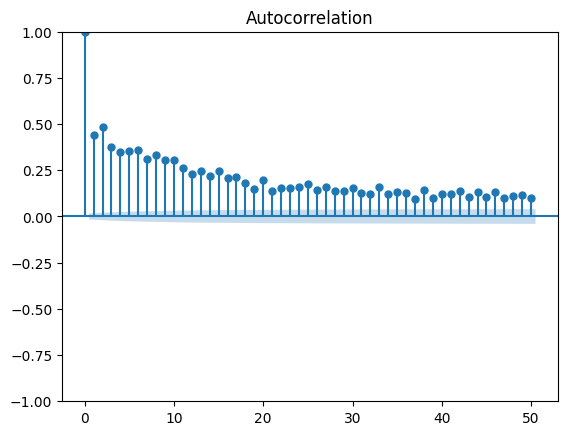

In [64]:
tsaplots.plot_acf(daily_diff[var], lags=50)
plt.show()

returns_sqr = map(lambda x: x*x , daily_diff[var])

tsaplots.plot_acf(list(returns_sqr), lags=50)
plt.show()

# tsaplots.plot_pacf(daily_diff[var],lags=50)
# plt.show()

## Lag plots of daily differences

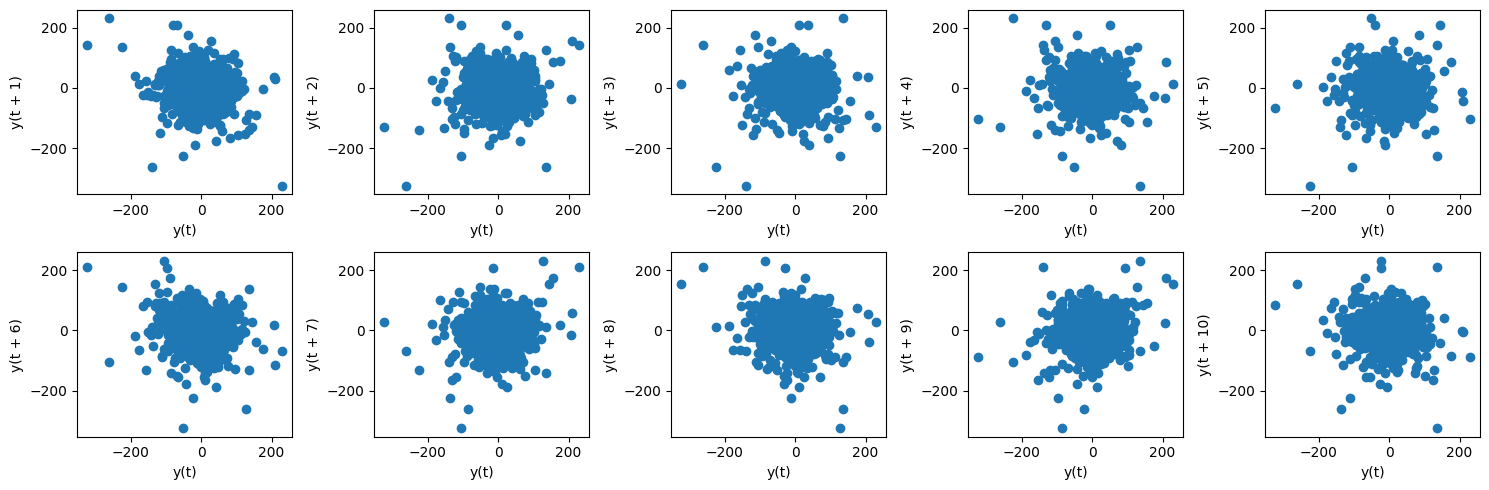

In [65]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

## Decomposition of daily differences

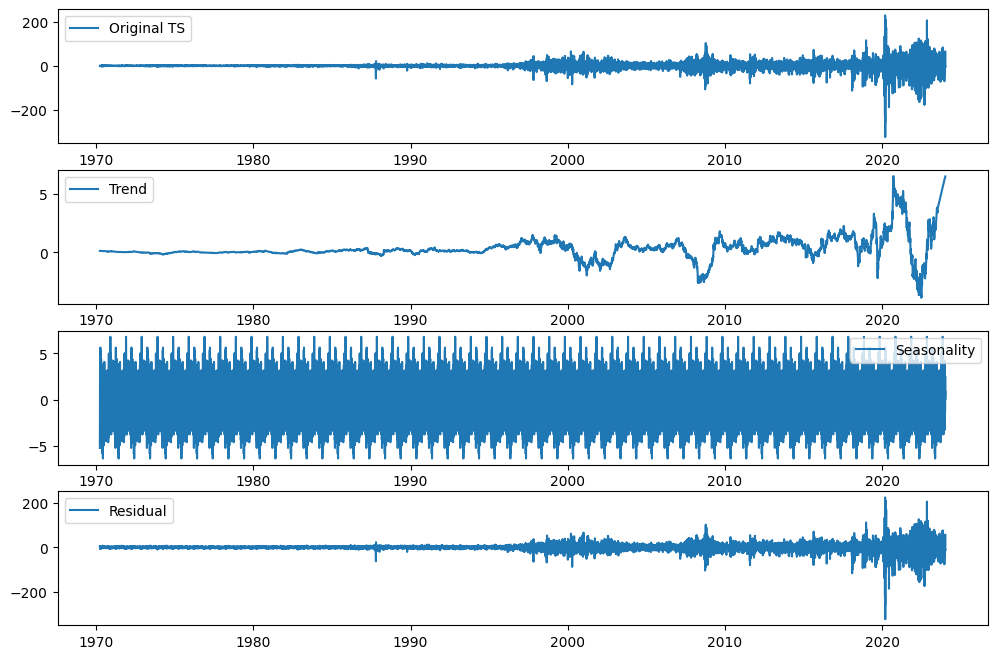

In [66]:
result_add = seasonal_decompose(daily_diff[var], model='additive',period=252, extrapolate_trend='freq' )

plot_decompostion(daily_diff,var,result_add)

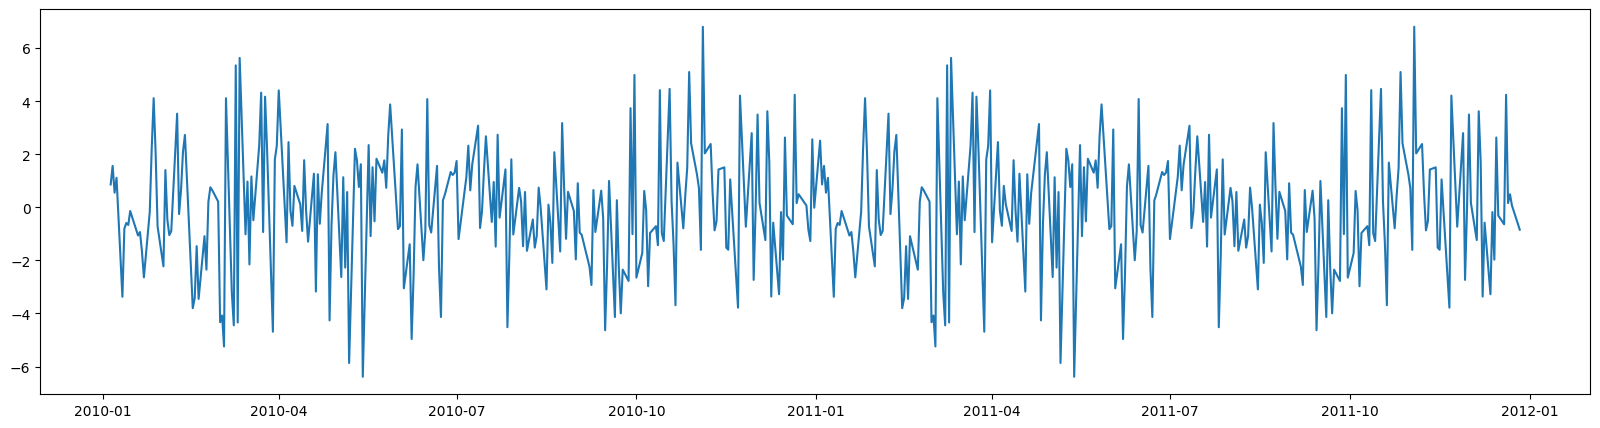

In [67]:
plt.figure(figsize=(20,5))
plt.plot(result_add.seasonal[10040:10540], label='Residual')
plt.show()

# Analysing the data monthly

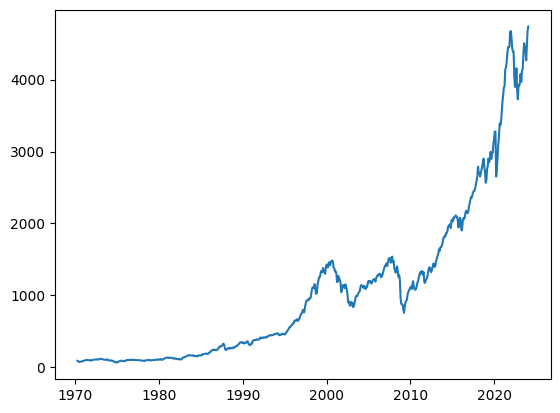

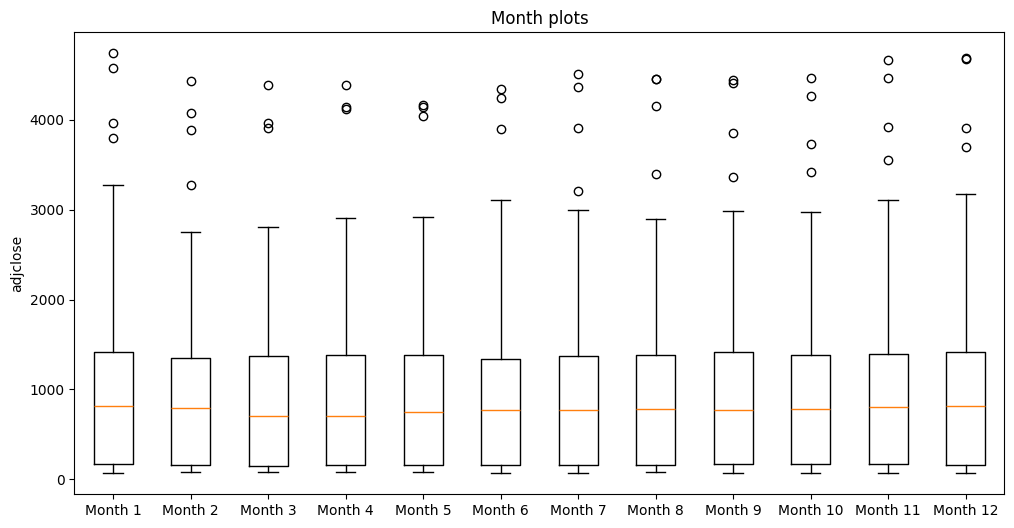

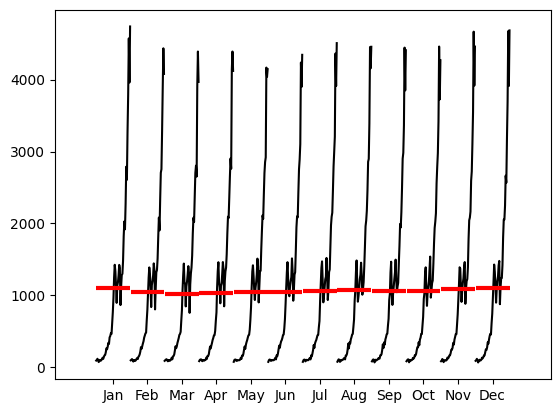

In [68]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()

fig = sm.graphics.tsa.month_plot(monthly_data[var])
plt.show()


## The evolution of the monthly difference

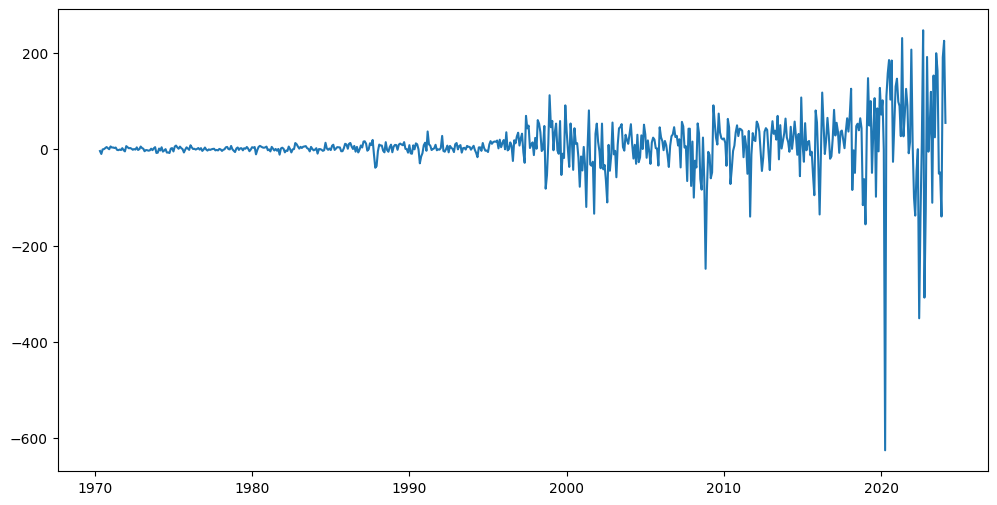

In [69]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

# Analysing the box-cox transformation

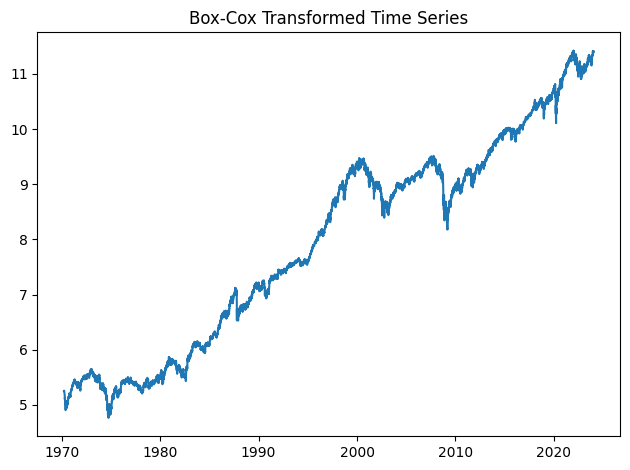

Optimal lambda value: 0.06721164744548437


In [70]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

## Decomposition of box-cox transformation

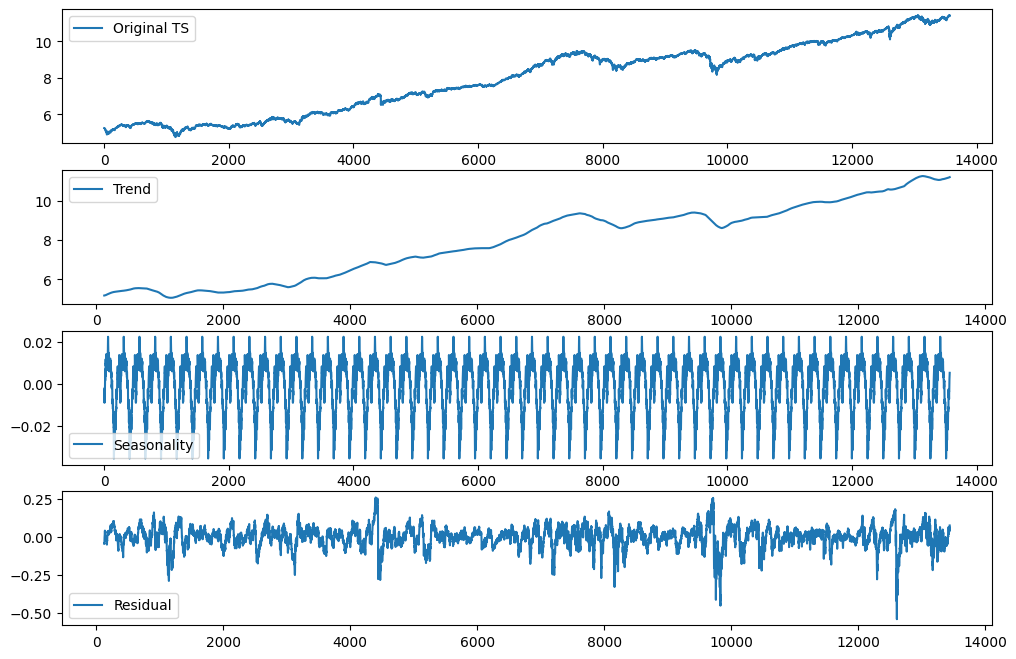

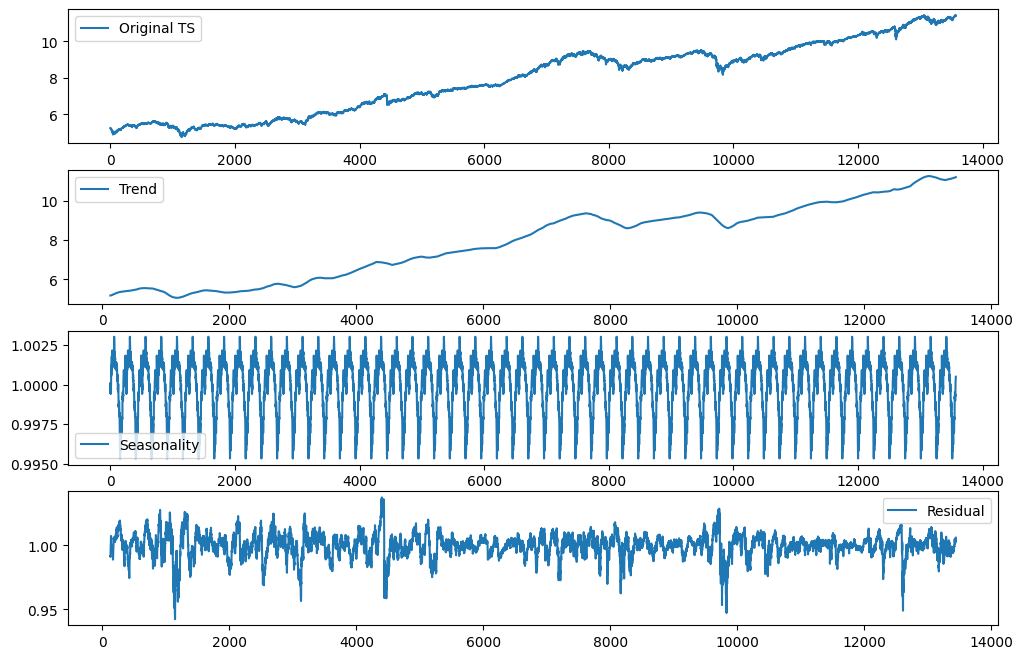

In [71]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

decompose_mult=seasonal_decompose(transformed_values, model='multiplicative', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mult.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mult.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mult.resid, label='Residual')
plt.legend(loc='best')

plt.show()

## Lag plots of box-cox transformation

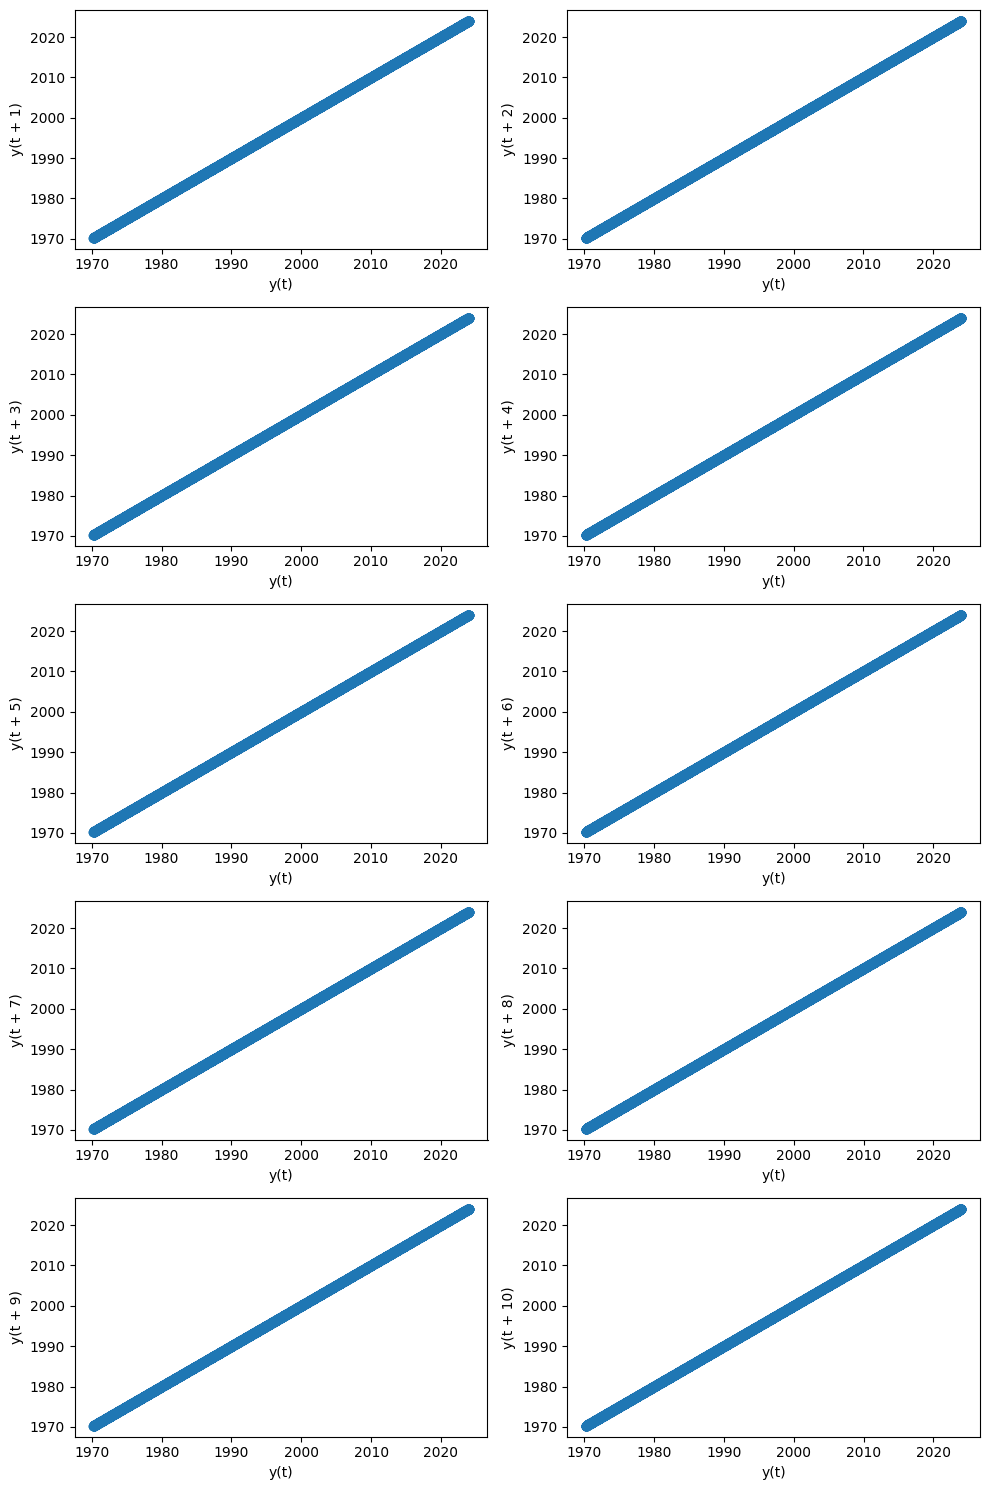

In [72]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

## ACF of box-cox transformation

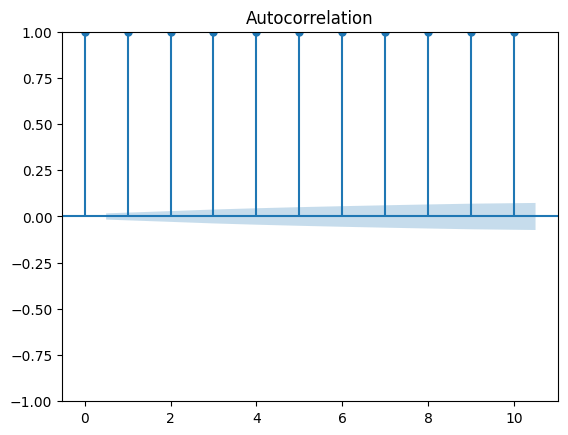

In [73]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()

In [74]:
daily_diff.describe()

open          high           low         close      adjclose  \
count  13569.000000  13569.000000  13569.000000  13569.000000  13569.000000   
mean       0.353168      0.346925      0.342801      0.345675      0.345675   
std       15.679994     13.587897     15.348954     17.219376     17.219376   
min     -194.739990   -164.650146   -228.359863   -324.890137   -324.890137   
25%       -1.699982     -1.539978     -1.680008     -1.869995     -1.869995   
50%        0.000000      0.110001      0.190002      0.139999      0.139999   
75%        2.970001      2.500000      2.869995      2.930054      2.930054   
max      170.039795    148.979980    172.180176    230.380127    230.380127   

             volume  
count  1.356900e+04  
mean   1.697575e+05  
std    4.460858e+08  
min   -5.044220e+09  
25%   -3.937000e+07  
50%    0.000000e+00  
75%    3.790000e+07  
max    4.637230e+09

# Model

In [163]:
returns = df['adjclose'].pct_change()
returns = returns[1:] *100
print(returns)
returns_sqr = list(map(lambda x:x*x,returns))

1970-03-26    0.167095
1970-03-30   -0.322510
1970-03-31    0.000000
1970-04-01    0.490910
1970-04-02   -0.310868
                ...   
2024-01-05    0.182569
2024-01-08    1.411463
2024-01-09   -0.147790
2024-01-10    0.566597
2024-01-11   -0.067106
Name: adjclose, Length: 13569, dtype: float64


Returns


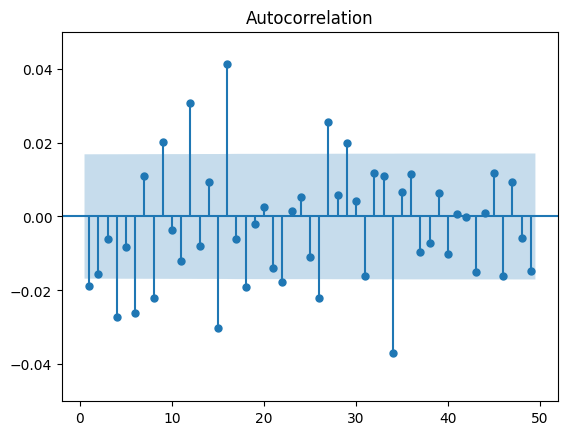

[ 1.         -0.01881288 -0.015684   -0.00611091 -0.02707384 -0.00830277
 -0.02621411  0.0109515  -0.02209139  0.0201572  -0.00361011]


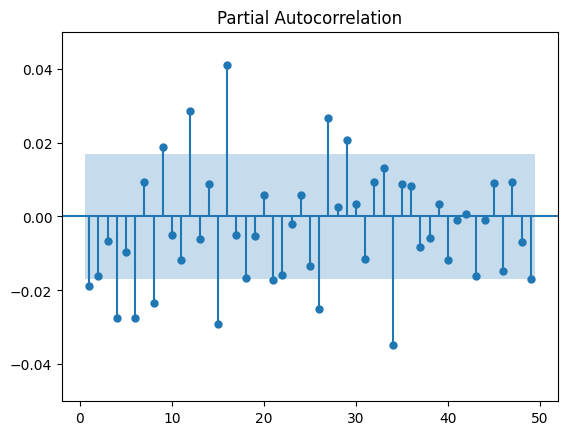

[ 1.         -0.01881427 -0.01604597 -0.00671812 -0.02759755 -0.00957957
 -0.02754401  0.00925451 -0.0235394   0.01880469 -0.00510294]


In [164]:
print("Returns")
acf= sm.tsa.acf(returns,nlags=10)
fig = tsaplots.plot_acf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns,nlags=10)
fig = tsaplots.plot_pacf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Returns square


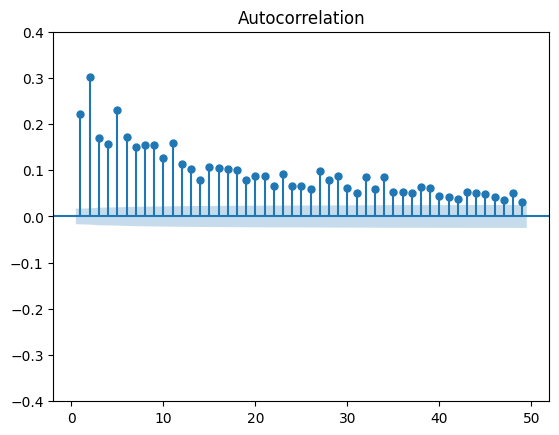

[1.         0.22138833 0.30176419 0.16881116 0.1571962  0.23097973
 0.17192389 0.15129118 0.15471146 0.15538151 0.12712068]


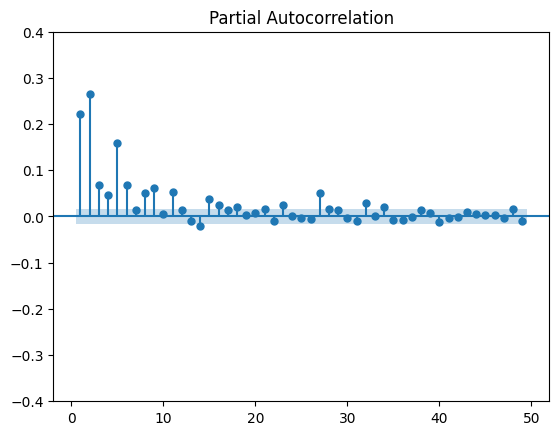

[1.         0.22140465 0.26581912 0.06894851 0.04636428 0.15818264
 0.06797345 0.01390166 0.05030689 0.06209401 0.00599029]


In [165]:
print("Returns square")
acf= sm.tsa.acf(returns_sqr,nlags=10)
fig = tsaplots.plot_acf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(pacf)

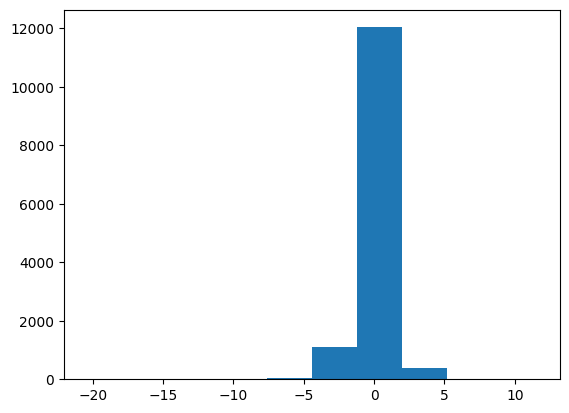

In [166]:
plt.hist(returns)
plt.show()

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


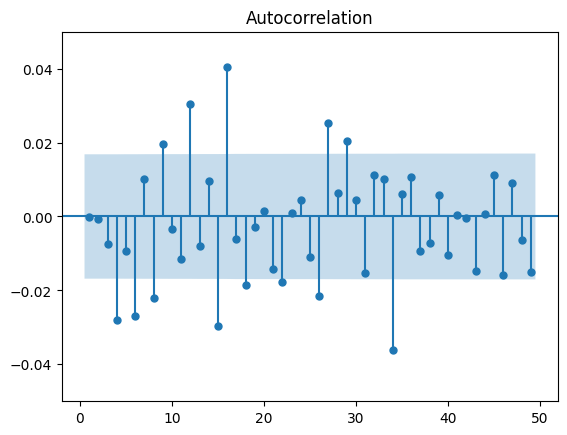

[ 1.00000000e+00 -1.08646768e-04 -5.58606955e-04 -7.39572121e-03
 -2.80686532e-02 -9.28351899e-03 -2.69853991e-02  1.02179122e-02
 -2.19922355e-02  1.96558486e-02 -3.33536662e-03]


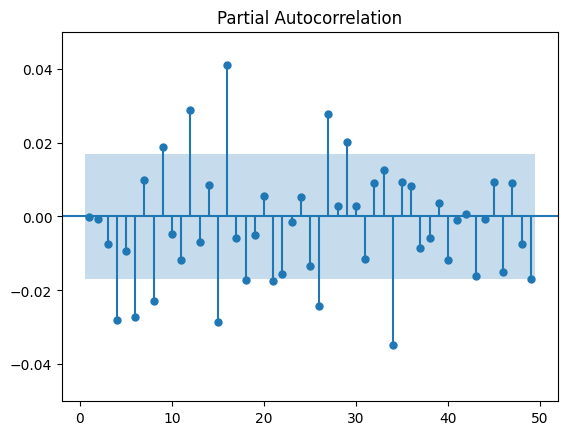

[ 1.00000000e+00 -1.08654777e-04 -5.58701127e-04 -7.39748078e-03
 -2.80804281e-02 -9.31524067e-03 -2.71175430e-02  9.77426055e-03
 -2.30133844e-02  1.87899798e-02 -4.87587063e-03]


In [167]:
model_ar = AutoReg(returns,lags=2)
results = model_ar.fit()

acf= sm.tsa.acf(results.resid,nlags=10)
fig = tsaplots.plot_acf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(results.resid,nlags=10)
fig = tsaplots.plot_pacf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 292914421400679.0
Iteration:      2,   Func. Count:     13,   Neg. LLF: 7521765945.716626
Iteration:      3,   Func. Count:     19,   Neg. LLF: 20433.708704800774
Iteration:      4,   Func. Count:     25,   Neg. LLF: 19475.923513651713
Iteration:      5,   Func. Count:     30,   Neg. LLF: 19436.44992456001
Iteration:      6,   Func. Count:     34,   Neg. LLF: 19436.44990043744
Iteration:      7,   Func. Count:     37,   Neg. LLF: 19436.44990043743
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19436.44990043744
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7


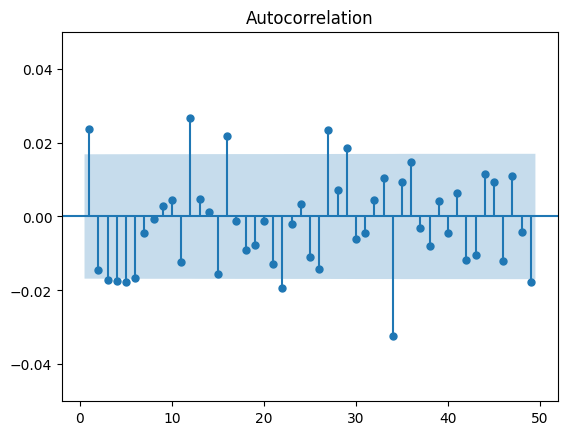

[ 1.00000000e+00  2.35803716e-02 -1.45067798e-02 -1.70557115e-02
 -1.75190551e-02 -1.77029368e-02 -1.67690333e-02 -4.58453411e-03
 -5.88018644e-04  2.91023228e-03  4.46662888e-03]


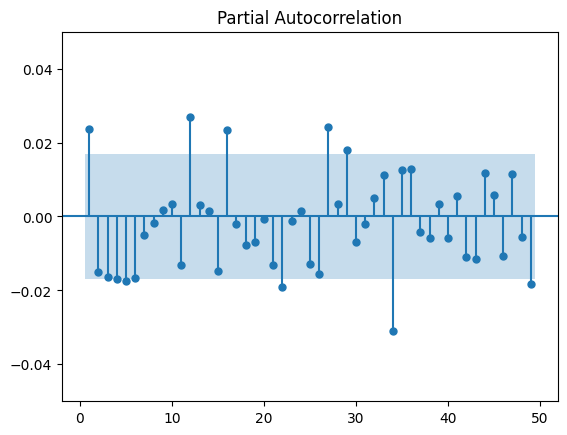

[ 1.          0.02358211 -0.01507342 -0.01636953 -0.01696488 -0.01740878
 -0.01676761 -0.00491516 -0.00175579  0.00166478  0.00329879]


In [168]:
model_arch = arch_model(returns,vol="ARCH",p=1)
result = model_arch.fit()

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 29444069206.206703
Iteration:      2,   Func. Count:     16,   Neg. LLF: 653411692.0071005
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.026933596862
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17799.76104206742
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.416197063474
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21612.537228309444
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.163901666907
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.20457867613
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.20295891889
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.202949750936
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.20294974722
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.202949750936
            Iterations: 11
            Function evaluations: 69
            Gradient evaluati

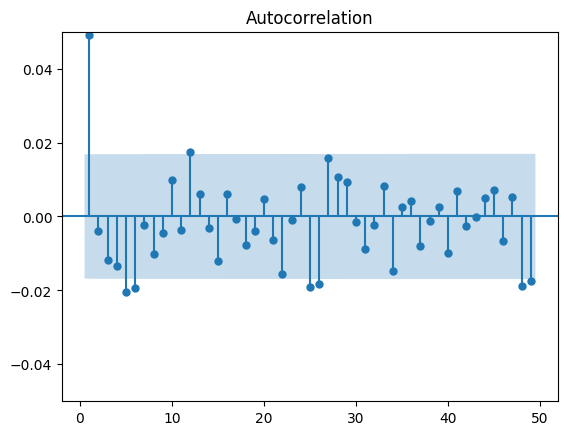

[ 1.          0.04917021 -0.00396595 -0.01172379 -0.0132714  -0.02049921
 -0.01943444 -0.00228776 -0.01007465 -0.0044683   0.00973543]


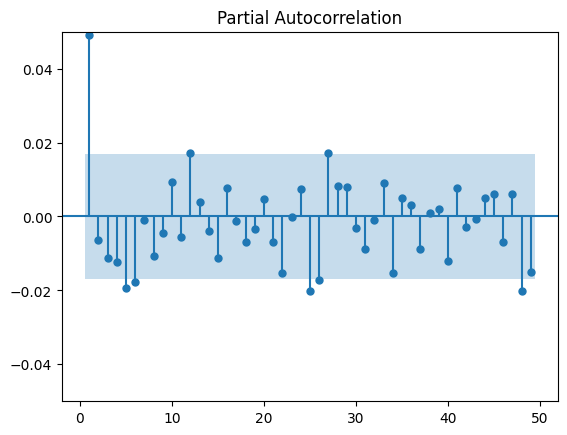

[ 1.00000000e+00  4.91738358e-02 -6.40007813e-03 -1.12430178e-02
 -1.21976880e-02 -1.94174029e-02 -1.77897913e-02 -9.52186053e-04
 -1.07458314e-02 -4.39351443e-03  9.22438114e-03]


In [172]:
model_garch = arch_model(returns,vol="GARCH",p=1,q=1)
result = model_garch.fit()

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

# Model v2

Returns square


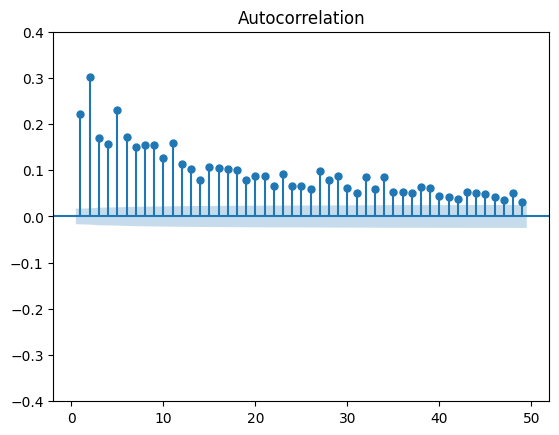

[1.         0.22138833 0.30176419 0.16881116 0.1571962  0.23097973
 0.17192389 0.15129118 0.15471146 0.15538151 0.12712068]


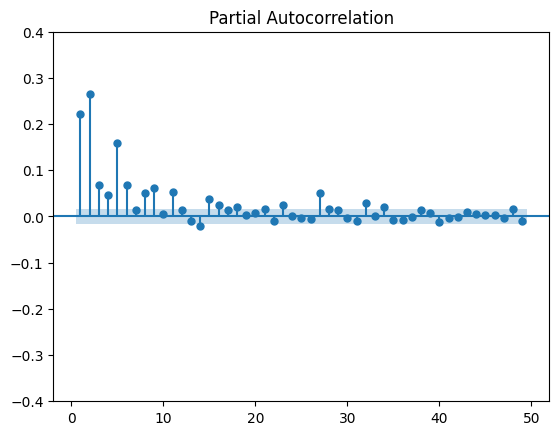

[1.         0.22140465 0.26581912 0.06894851 0.04636428 0.15818264
 0.06797345 0.01390166 0.05030689 0.06209401 0.00599029]


In [102]:
print("Returns square")
acf= sm.tsa.acf(returns_sqr,nlags=10)
fig = tsaplots.plot_acf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(pacf)

In [103]:
model1 = arch_model(returns,vol="GARCH",p=1,q=1)
results1 = model1.fit()

model2 = arch_model(returns,vol="GARCH",p=2,q=1)
results2 = model2.fit()

model3 = arch_model(returns,vol="GARCH",p=3,q=1)
results3 = model3.fit()

model4 = arch_model(returns,vol="GARCH",p=4,q=1)
results4 = model4.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 29444069206.206703
Iteration:      2,   Func. Count:     16,   Neg. LLF: 653411692.0071005
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.026933596862
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17799.76104206742
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.416197063474
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21612.537228309444
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.163901666907
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.20457867613
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.20295891889
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.202949750936
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.20294974722
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.202949750936
            Iterations: 11
            Function evaluations: 69
            Gradient evaluati

In [104]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35514.40589950187
35516.40589942543
35518.40589922337
35520.40589916377
35544.46807173445
35553.98361471616
35563.499157572245
35573.01470057079
-17753.202949750936
-17753.202949712715
-17753.202949611685
-17753.202949581886


In [105]:
model1 = arch_model(returns,vol="GARCH",p=1,q=1)
results1 = model1.fit()

model2 = arch_model(returns,vol="GARCH",p=1,q=2)
results2 = model2.fit()

model3 = arch_model(returns,vol="GARCH",p=1,q=3)
results3 = model3.fit()

model4 = arch_model(returns,vol="GARCH",p=1,q=4)
results4 = model4.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 29444069206.206703
Iteration:      2,   Func. Count:     16,   Neg. LLF: 653411692.0071005
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.026933596862
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17799.76104206742
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.416197063474
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21612.537228309444
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.163901666907
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.20457867613
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.20295891889
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.202949750936
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.20294974722
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.202949750936
            Iterations: 11
            Function evaluations: 69
            Gradient evaluati

In [106]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35514.40589950187
35516.17694233917
35516.026201341985
35517.96094758416
35544.46807173445
35553.7546576299
35561.11945969086
35570.569748991176
-17753.202949750936
-17753.088471169583
-17752.013100670993
-17751.98047379208


# Final model

In [175]:
train_size = 0.8
train_data, test_data = train_test_split(returns, train_size=train_size, shuffle=False)

In [176]:
model_final = arch_model(train_data,vol="GARCH",p=1,q=1)

results_final = model_final.fit(disp='off')
print(results_final.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               adjclose   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14315.2
Distribution:                  Normal   AIC:                           28638.4
Method:            Maximum Likelihood   BIC:                           28667.6
                                        No. Observations:                10855
Date:                Fri, Jan 12 2024   Df Residuals:                    10854
Time:                        02:39:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0508  8.043e-03      6.313  2.730e-10 [3.

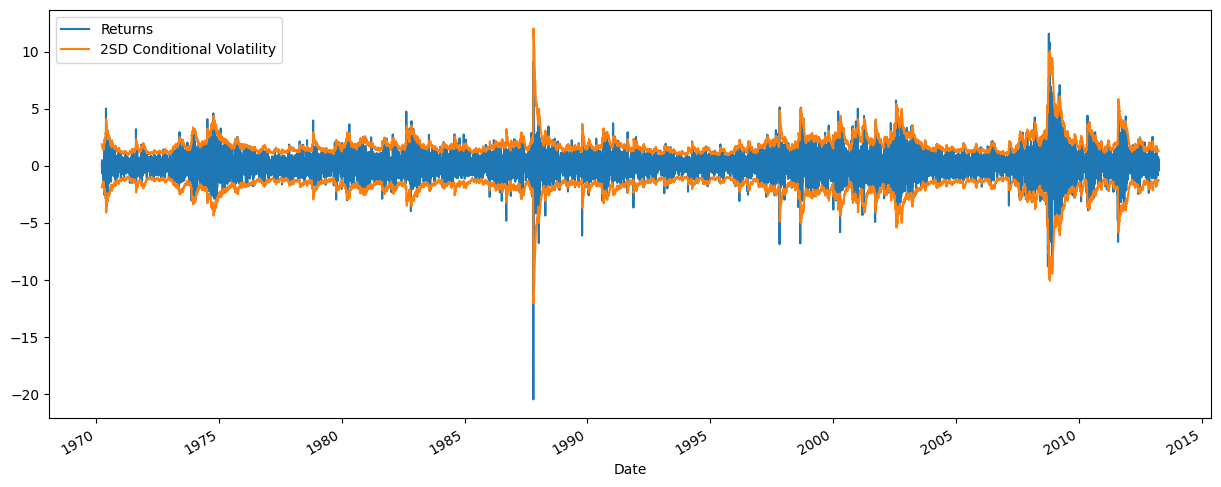

In [178]:
plt.subplots(figsize=(15, 6))

train_data.plot(label='Returns')

(2 * results_final.conditional_volatility).plot(color='C1',label='2SD Conditional Volatility')

(-2 * results_final.conditional_volatility).rename('').plot(color='C1')

plt.xlabel('Date')

plt.legend()
plt.show()

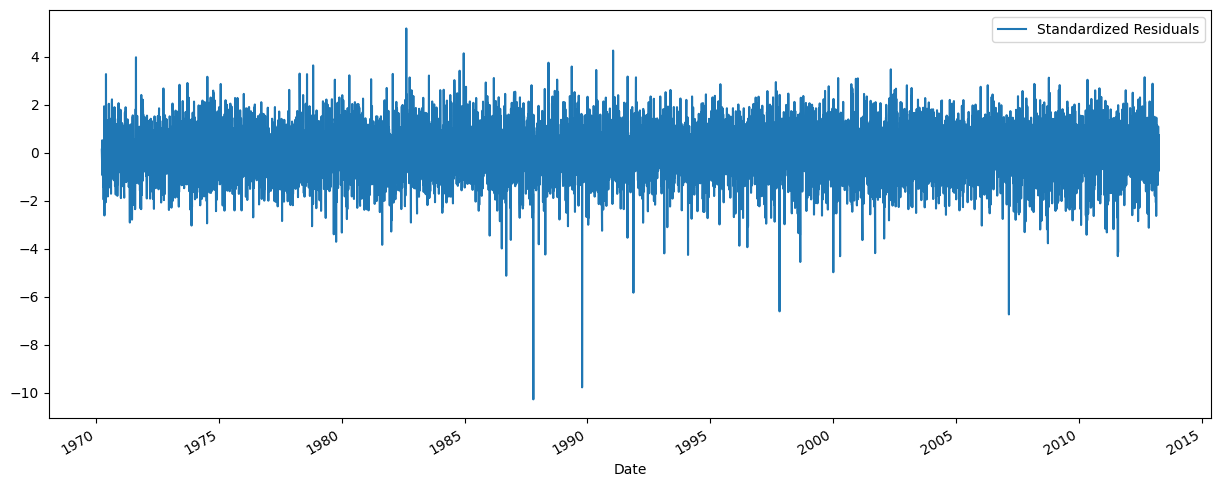

In [146]:
plt.subplots(figsize=(15, 6))

results_final.std_resid.plot(label='Standardized Residuals')

plt.xlabel('Date')
plt.legend()
plt.show()

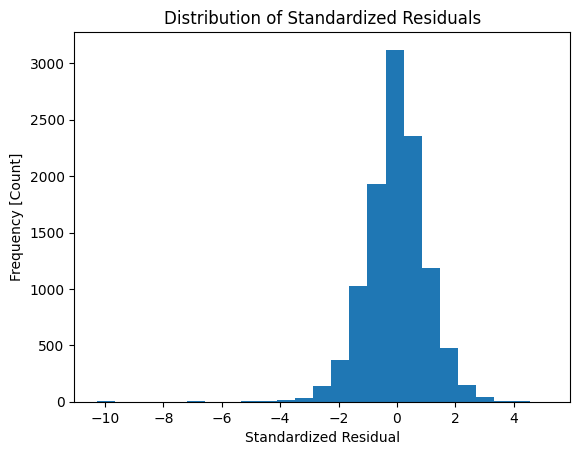

In [142]:
plt.hist(results_final.std_resid, bins=25)

plt.xlabel('Standardized Residual')
plt.ylabel('Frequency [Count]')

plt.title('Distribution of Standardized Residuals')
plt.show()

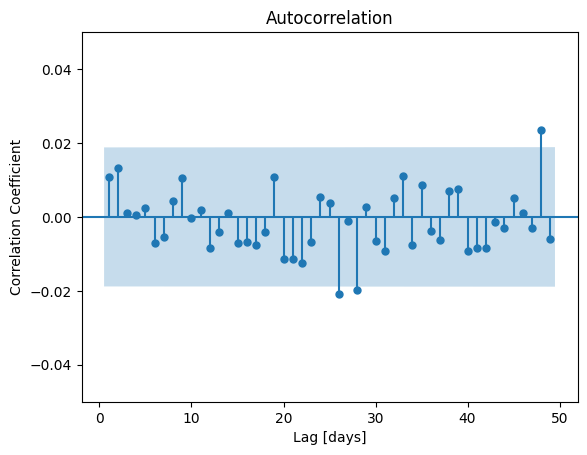

In [157]:
tsaplots.plot_acf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

In [161]:
predictions = []

test_size = int(len(returns) *0.2)

for i in range(test_size):
    train_data = returns.iloc[:-(test_size-i)]

    model = arch_model(train_data,vol="GARCH",p=1,q=1)
    results_arch = model.fit()

    next_pred = results_arch.forecast(horizon=1,reindex=False).variance.iloc[0,0] ** 0.5

    #train_data = pd.concat([train_data,pd.Series([next_pred])])
    
    predictions.append(next_pred)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 414825845486.15564
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5994289839.858743
Iteration:      3,   Func. Count:     25,   Neg. LLF: 62710438.31801239
Iteration:      4,   Func. Count:     31,   Neg. LLF: 14400.265205430751
Iteration:      5,   Func. Count:     37,   Neg. LLF: 14367.873623939282
Iteration:      6,   Func. Count:     43,   Neg. LLF: 14327.407367028187
Iteration:      7,   Func. Count:     49,   Neg. LLF: 14519.065444760106
Iteration:      8,   Func. Count:     55,   Neg. LLF: 14328.808654945666
Iteration:      9,   Func. Count:     62,   Neg. LLF: 14318.939652855639
Iteration:     10,   Func. Count:     68,   Neg. LLF: 14317.194247732881
Iteration:     11,   Func. Count:     73,   Neg. LLF: 14317.19294526451
Iteration:     12,   Func. Count:     78,   Neg. LLF: 14317.192944625745
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14317.192944625745
            Iterat

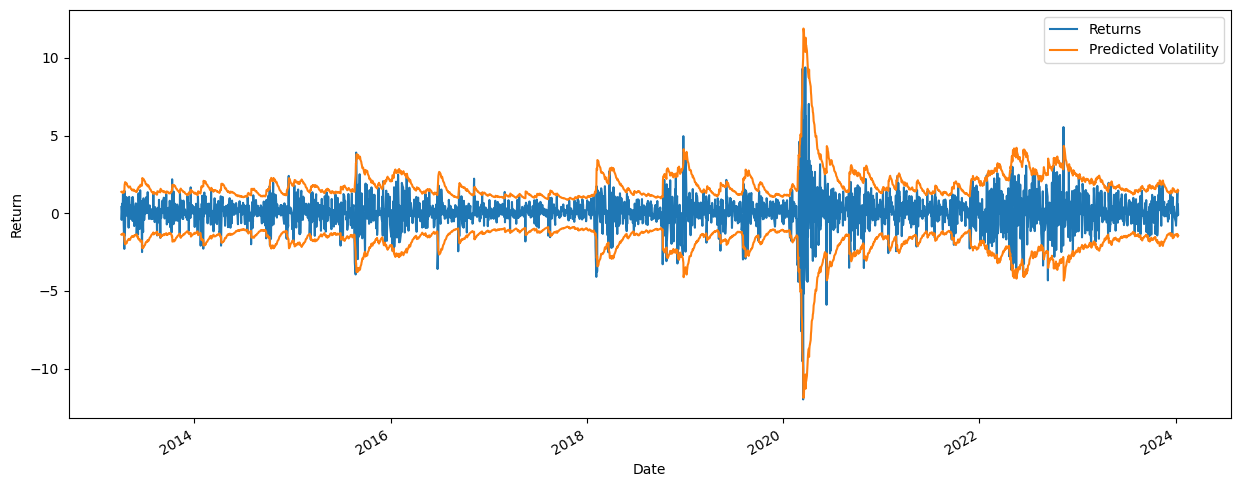

In [180]:
data_test_wfv = pd.Series(predictions, index=returns.tail(test_size).index)

plt.subplots(figsize=(15, 6))
returns.tail(test_size).plot( label="Returns")

(2 * data_test_wfv).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv).plot(c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()